Loading DAMASK output from: 3grains_inc24.vti
Grid: 10 x 10 x 10 cells
Cell size: 100.0 μm
Loaded quaternions with shape: (1000, 4)
Detecting grains from orientation data...
Loaded deformation gradient F
Loaded plastic deformation gradient F_p
Loaded stress tensor
Calculating KAM...
Stored energy range: 8.24e+05 - 2.40e+07 J/m³
Detected 81 grains
Mean stored energy: 5.98e+06 J/m³
Initial boundary cells: 992
Initialized 3D CA with grid size: 10 x 10 x 10
Total cells: 1000

Starting simulation...
Max time: 100.0s
Max steps: 10000
Save interval: 50 steps
Saved initial state to output_damask_ca_simulation/step_000000.vti
Step 50: t=50.000s, Rex=0.001, Grains=81, Elapsed=9.8s
Step 100: t=100.000s, Rex=0.006, Grains=81, Elapsed=19.6s

Simulation completed:
  Total steps: 100
  Final time: 100.000s
  Final rex fraction: 0.006
  Output saved to: output_damask_ca_simulation


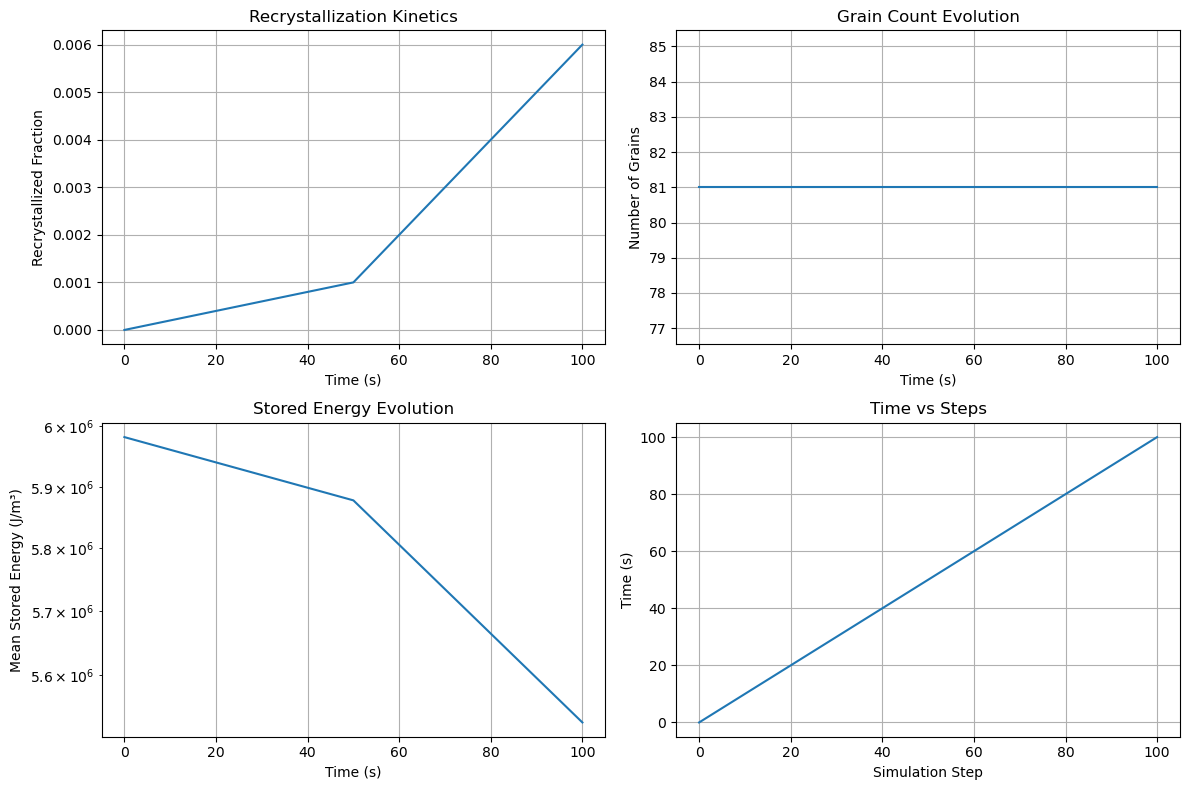

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
import yaml
import vtk
from vtk.util import numpy_support
import os
import time
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN

class CellularAutomatonRexGG3D:
    """
    3D Cellular Automaton for Recrystallization and Grain Growth
    Modified to read DAMASK VTI output files
    """
    
    def __init__(self, config_file: str):
        """Initialize from YAML configuration file"""
        # Load configuration
        with open(config_file, 'r') as f:
            self.config = yaml.safe_load(f)
        
        # Material parameters from config
        self.grain_boundary_energy = self.config['material']['grain_boundary_energy']
        self.mobility_pre_exponential = self.config['material']['mobility_pre_exponential']
        self.activation_energy = self.config['material']['activation_energy']
        self.temperature = self.config['material']['temperature']
        self.R = 8.314  # J/(mol·K)
        
        # Misorientation thresholds
        self.min_misorientation = self.config['thresholds']['min_misorientation']
        self.lagb_threshold = self.config['thresholds']['lagb_threshold']
        self.hagb_threshold = self.config['thresholds']['hagb_threshold']
        
        # Stored energy parameters
        self.stored_energy_factor = self.config['energy']['stored_energy_factor']
        self.max_kam_degrees = self.config['energy']['max_kam_degrees']
        
        # Kinetic factor
        self.beta_factor = self.config['kinetics']['beta_factor']
        
        # Simulation parameters
        self.max_time = self.config['simulation']['max_time']
        self.max_steps = self.config['simulation']['max_steps']
        self.save_interval = self.config['simulation']['save_interval']
        self.output_dir = self.config['simulation']['output_directory']
        
        # Grain detection parameters
        self.grain_detection_threshold = self.config.get('grain_detection', {}).get('misorientation_threshold', 5.0)
        
        # Create output directory
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        
        # Initialize cache before loading microstructure
        self._misorientation_cache = {}
        
        # Load initial microstructure
        self.initial_microstructure_path = self.config['initial_microstructure']['path']
        self._load_initial_microstructure_damask()
        
        # Initialize cellular automaton state
        self._initialize_ca_state()
        
        # Statistics tracking
        self.total_time = 0.0
        self.step_count = 0
        
        print(f"Initialized 3D CA with grid size: {self.nx} x {self.ny} x {self.nz}")
        print(f"Total cells: {self.n_cells}")
    
    def _load_initial_microstructure_damask(self):
        """Load initial microstructure from DAMASK VTI file"""
        print(f"Loading DAMASK output from: {self.initial_microstructure_path}")
        
        # Read VTI file
        reader = vtk.vtkXMLImageDataReader()
        reader.SetFileName(self.initial_microstructure_path)
        reader.Update()
        
        # Get the image data
        image_data = reader.GetOutput()
        
        # Get dimensions (note: VTI has points, we need cells)
        dims = image_data.GetDimensions()
        self.nx = dims[0] - 1  # cells = points - 1
        self.ny = dims[1] - 1
        self.nz = dims[2] - 1
        self.n_cells = self.nx * self.ny * self.nz
        
        # Get spacing (cell size)
        spacing = image_data.GetSpacing()
        self.dx = spacing[0]  # Already in meters for DAMASK output
        
        print(f"Grid: {self.nx} x {self.ny} x {self.nz} cells")
        print(f"Cell size: {self.dx*1e6:.1f} μm")
        
        # Get cell data (DAMASK stores data on cells, not points)
        cell_data = image_data.GetCellData()
        
        # Extract quaternions from 'phase/mechanical/O / 1'
        quat_array = cell_data.GetArray('phase/mechanical/O / 1')
        if quat_array is None:
            raise ValueError("Quaternion array 'phase/mechanical/O / 1' not found in VTI file")
        
        quaternions_data = numpy_support.vtk_to_numpy(quat_array)
        print(f"Loaded quaternions with shape: {quaternions_data.shape}")
        
        # Detect grains based on orientation similarity
        print("Detecting grains from orientation data...")
        self.orientation_id, self.quaternions = self._detect_grains_from_quaternions(quaternions_data)
        
        # Extract deformation data to estimate stored energy
        self._extract_deformation_data(cell_data)
        
        # Calculate KAM
        print("Calculating KAM...")
        self.kam = np.zeros(self.n_cells)
        self._calculate_kam()
        
        # Set stored energy
        self._set_stored_energy_from_deformation()
        
        print(f"Detected {len(self.quaternions)} grains")
        print(f"Mean stored energy: {np.mean(self.stored_energy):.2e} J/m³")
    
    def _detect_grains_from_quaternions(self, quaternions_data):
        """Detect grains by clustering cells with similar orientations"""
        n_cells = quaternions_data.shape[0]
        
        # Method 1: Simple misorientation-based clustering
        orientation_id = np.zeros(n_cells, dtype=int)
        unique_quaternions = {}
        current_grain_id = 0
        
        # Process cells and group by orientation
        for cell_idx in range(n_cells):
            q_cell = quaternions_data[cell_idx]
            
            # Check if this orientation is similar to existing grains
            assigned = False
            for grain_id, q_grain in unique_quaternions.items():
                misorientation = self._calculate_misorientation_from_quaternions(q_cell, q_grain)
                if misorientation < self.grain_detection_threshold:
                    orientation_id[cell_idx] = grain_id
                    assigned = True
                    break
            
            # If not similar to any existing grain, create new grain
            if not assigned:
                orientation_id[cell_idx] = current_grain_id
                unique_quaternions[current_grain_id] = q_cell.copy()
                current_grain_id += 1
        
        # Method 2: Alternative - spatial clustering with orientation
        if len(unique_quaternions) == 1:
            print("Only one orientation detected. Attempting spatial clustering...")
            orientation_id, unique_quaternions = self._spatial_grain_detection(quaternions_data)
        
        return orientation_id, unique_quaternions
    
    def _spatial_grain_detection(self, quaternions_data):
        """Detect grains using spatial clustering combined with orientation"""
        # Create a feature vector combining position and orientation
        features = []
        
        for cell_idx in range(self.n_cells):
            i, j, k = self._cell_to_indices(cell_idx)
            # Normalize spatial coordinates
            x = i / self.nx
            y = j / self.ny
            z = k / self.nz
            
            # Get quaternion
            q = quaternions_data[cell_idx]
            
            # Combine spatial and orientation info
            # Weight orientation more heavily
            spatial_weight = 0.1
            orientation_weight = 1.0
            
            feature = np.concatenate([
                [x * spatial_weight, y * spatial_weight, z * spatial_weight],
                q * orientation_weight
            ])
            features.append(feature)
        
        features = np.array(features)
        
        # Use DBSCAN clustering
        clustering = DBSCAN(eps=0.15, min_samples=10).fit(features)
        labels = clustering.labels_
        
        # Handle noise points (-1 label)
        if -1 in labels:
            # Assign noise points to nearest cluster
            noise_mask = labels == -1
            non_noise_mask = ~noise_mask
            
            if np.any(non_noise_mask):
                tree = cKDTree(features[non_noise_mask])
                for idx in np.where(noise_mask)[0]:
                    _, nearest_idx = tree.query(features[idx])
                    labels[idx] = labels[np.where(non_noise_mask)[0][nearest_idx]]
        
        # Create unique quaternions dictionary
        unique_quaternions = {}
        for grain_id in np.unique(labels):
            if grain_id >= 0:
                grain_cells = np.where(labels == grain_id)[0]
                # Use average quaternion for the grain
                avg_q = np.mean(quaternions_data[grain_cells], axis=0)
                # Normalize
                avg_q = avg_q / np.linalg.norm(avg_q)
                unique_quaternions[grain_id] = avg_q
        
        return labels, unique_quaternions
    
    def _extract_deformation_data(self, cell_data):
        """Extract deformation data from DAMASK output"""
        # Try to get deformation gradient
        F_array = cell_data.GetArray('phase/mechanical/F / 1')
        if F_array:
            self.F = numpy_support.vtk_to_numpy(F_array).reshape(-1, 3, 3)
            print("Loaded deformation gradient F")
        else:
            self.F = None
        
        # Try to get plastic deformation gradient
        Fp_array = cell_data.GetArray('phase/mechanical/F_p / 1')
        if Fp_array:
            self.Fp = numpy_support.vtk_to_numpy(Fp_array).reshape(-1, 3, 3)
            print("Loaded plastic deformation gradient F_p")
        else:
            self.Fp = None
        
        # Try to get stress
        sigma_array = cell_data.GetArray('phase/mechanical/sigma / Pa')
        if sigma_array:
            self.sigma = numpy_support.vtk_to_numpy(sigma_array).reshape(-1, 3, 3)
            print("Loaded stress tensor")
        else:
            self.sigma = None
    
    def _set_stored_energy_from_deformation(self):
        """Calculate stored energy from deformation data"""
        self.stored_energy = np.zeros(self.n_cells)
        
        if self.Fp is not None:
            # Calculate equivalent plastic strain from Fp
            for i in range(self.n_cells):
                # Green-Lagrange strain tensor from Fp
                Cp = np.dot(self.Fp[i].T, self.Fp[i])
                Ep = 0.5 * (Cp - np.eye(3))
                
                # Von Mises equivalent strain
                eq_strain = np.sqrt(2/3 * np.sum(Ep**2))
                
                # Stored energy proportional to plastic strain squared
                self.stored_energy[i] = self.stored_energy_factor * eq_strain**2
        else:
            # If no deformation data, use KAM-based estimate
            print("No plastic deformation data found, using KAM-based stored energy")
            normalized_kam = self.kam / self.max_kam_degrees
            self.stored_energy = self.stored_energy_factor * (normalized_kam ** 1.5)
        
        # Add some noise to avoid zero energy
        self.stored_energy += np.random.uniform(0.01, 0.1) * self.stored_energy_factor
        
        print(f"Stored energy range: {np.min(self.stored_energy):.2e} - {np.max(self.stored_energy):.2e} J/m³")
    
    def _calculate_misorientation_from_quaternions(self, q1, q2):
        """Calculate misorientation angle between two quaternions"""
        # Normalize quaternions
        q1 = q1 / np.linalg.norm(q1)
        q2 = q2 / np.linalg.norm(q2)
        
        # Calculate dot product
        dot = np.abs(np.dot(q1, q2))
        dot = min(dot, 1.0)  # Clamp to avoid numerical errors
        
        # Calculate misorientation angle
        angle_rad = 2.0 * np.arccos(dot)
        angle_deg = np.degrees(angle_rad)
        
        # Apply cubic symmetry
        return min(angle_deg, 62.8)
    
    def _initialize_ca_state(self):
        """Initialize cellular automaton state arrays"""
        # CA state
        self.consumption_rate = np.zeros(self.n_cells)
        self.consumed_fraction = np.zeros(self.n_cells)
        self.growing_neighbor = -np.ones(self.n_cells, dtype=int)
        
        # Tracking
        self.boundary_cells = set()
        self.is_recrystallized = np.zeros(self.n_cells, dtype=bool)
        
        # Identify initial boundary cells
        self._identify_boundary_cells()
        
        print(f"Initial boundary cells: {len(self.boundary_cells)}")
    
    def euler_to_quaternion(self, phi1, Phi, phi2):
        """Convert Euler angles (degrees) to quaternion"""
        # Convert to radians
        phi1 = np.radians(phi1)
        Phi = np.radians(Phi)
        phi2 = np.radians(phi2)
        
        # Calculate quaternion components
        c1 = np.cos(phi1/2)
        c2 = np.cos(Phi/2)
        c3 = np.cos(phi2/2)
        s1 = np.sin(phi1/2)
        s2 = np.sin(Phi/2)
        s3 = np.sin(phi2/2)
        
        w = c1*c2*c3 + s1*s2*s3
        x = c1*c2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*c2*s3
        z = s1*c2*c3 - c1*s2*s3
        
        # Normalize
        norm = np.sqrt(w*w + x*x + y*y + z*z)
        return (w/norm, x/norm, y/norm, z/norm)
    
    def quaternion_multiply(self, q1, q2):
        """Multiply two quaternions"""
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        
        w = w1*w2 - x1*x2 - y1*y2 - z1*z2
        x = w1*x2 + x1*w2 + y1*z2 - z1*y2
        y = w1*y2 - x1*z2 + y1*w2 + z1*x2
        z = w1*z2 + x1*y2 - y1*x2 + z1*w2
        
        return (w, x, y, z)
    
    def quaternion_conjugate(self, q):
        """Get conjugate of quaternion"""
        w, x, y, z = q
        return (w, -x, -y, -z)
    
    def _cell_to_indices(self, cell_idx: int) -> Tuple[int, int, int]:
        """Convert flat cell index to 3D indices"""
        i = cell_idx // (self.ny * self.nz)
        j = (cell_idx % (self.ny * self.nz)) // self.nz
        k = cell_idx % self.nz
        return i, j, k
    
    def _indices_to_cell(self, i: int, j: int, k: int) -> int:
        """Convert 3D indices to flat cell index"""
        return i * self.ny * self.nz + j * self.nz + k
    
    def _get_neighbors(self, cell_idx: int) -> List[int]:
        """Get Von Neumann neighbors (6-connectivity in 3D)"""
        i, j, k = self._cell_to_indices(cell_idx)
        neighbors = []
        
        for di, dj, dk in [(-1,0,0), (1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]:
            ni = i + di
            nj = j + dj
            nk = k + dk
            if 0 <= ni < self.nx and 0 <= nj < self.ny and 0 <= nk < self.nz:
                neighbors.append(self._indices_to_cell(ni, nj, nk))
        
        return neighbors
    
    def _get_all_neighbors(self, cell_idx: int) -> List[int]:
        """Get Moore neighbors (26-connectivity in 3D)"""
        i, j, k = self._cell_to_indices(cell_idx)
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                for dk in [-1, 0, 1]:
                    if di == 0 and dj == 0 and dk == 0:
                        continue
                    ni = i + di
                    nj = j + dj
                    nk = k + dk
                    if 0 <= ni < self.nx and 0 <= nj < self.ny and 0 <= nk < self.nz:
                        neighbors.append(self._indices_to_cell(ni, nj, nk))
        
        return neighbors
    
    def _calculate_misorientation_quaternion(self, ori_id1: int, ori_id2: int) -> float:
        """Calculate misorientation between two orientations using quaternions with caching"""
        if ori_id1 == ori_id2:
            return 0.0
        
        # Check cache
        key = (min(ori_id1, ori_id2), max(ori_id1, ori_id2))
        if key in self._misorientation_cache:
            return self._misorientation_cache[key]
        
        q1 = self.quaternions.get(ori_id1, (1, 0, 0, 0))
        q2 = self.quaternions.get(ori_id2, (1, 0, 0, 0))
        
        # Calculate misorientation quaternion: q_mis = q1^(-1) * q2
        q1_conj = self.quaternion_conjugate(q1)
        q_mis = self.quaternion_multiply(q1_conj, q2)
        
        # Extract misorientation angle
        w = min(max(q_mis[0], -1.0), 1.0)  # Clamp to avoid numerical errors
        angle_rad = 2.0 * np.arccos(abs(w))
        angle_deg = np.degrees(angle_rad)
        
        # Apply crystal symmetry (simplified - for cubic symmetry)
        result = min(angle_deg, 62.8)
        
        # Cache result
        self._misorientation_cache[key] = result
        return result
    
    def _calculate_kam(self):
        """Calculate Kernel Average Misorientation for each cell"""
        for cell_idx in range(self.n_cells):
            neighbors = self._get_all_neighbors(cell_idx)
            
            if len(neighbors) == 0:
                self.kam[cell_idx] = 0.0
                continue
            
            total_misorientation = 0.0
            n_boundaries = 0
            
            for nbr in neighbors:
                mis = self._calculate_misorientation_quaternion(
                    self.orientation_id[cell_idx],
                    self.orientation_id[nbr]
                )
                
                if mis > self.min_misorientation:
                    total_misorientation += mis
                    n_boundaries += 1
            
            if n_boundaries > 0:
                self.kam[cell_idx] = total_misorientation / n_boundaries
            else:
                self.kam[cell_idx] = 0.0
    
    def _identify_boundary_cells(self):
        """Identify cells at boundaries"""
        self.boundary_cells.clear()
        
        for cell_idx in range(self.n_cells):
            neighbors = self._get_neighbors(cell_idx)
            
            for nbr in neighbors:
                if self.orientation_id[cell_idx] != self.orientation_id[nbr]:
                    mis = self._calculate_misorientation_quaternion(
                        self.orientation_id[cell_idx],
                        self.orientation_id[nbr]
                    )
                    if mis > self.min_misorientation:
                        self.boundary_cells.add(cell_idx)
                        break
    
    def _get_boundary_energy(self, misorientation: float) -> float:
        """Read-Shockley model for boundary energy"""
        if misorientation < self.min_misorientation:
            return 0.0
        
        if misorientation >= self.hagb_threshold:
            return self.grain_boundary_energy
        
        # Read-Shockley equation
        theta_m = self.hagb_threshold * np.pi / 180
        theta = misorientation * np.pi / 180
        
        return self.grain_boundary_energy * (theta / theta_m) * (1 - np.log(theta / theta_m))
    
    def _get_mobility(self, misorientation: float) -> float:
        """Get boundary mobility with misorientation dependence"""
        if misorientation < self.min_misorientation:
            return 0.0
        
        # Base mobility with Arrhenius temperature dependence
        M0 = self.mobility_pre_exponential * np.exp(-self.activation_energy / (self.R * self.temperature))
        
        if misorientation >= self.hagb_threshold:
            return M0
        else:
            # Reduced mobility for low angle boundaries
            return M0 * (misorientation / self.hagb_threshold) ** 2
    
    def calculate_reorientation_rates(self) -> float:
        """Calculate growth rates based on energy minimization"""
        max_rate = 0.0
        mean_stored_energy = np.mean(self.stored_energy)
        
        # Reset
        self.consumption_rate.fill(0.0)
        self.growing_neighbor.fill(-1)
        
        for cell_idx in self.boundary_cells:
            current_ori = self.orientation_id[cell_idx]
            
            # Calculate current cell's boundary energy per unit area
            current_boundary_energy = 0.0
            for nbr in self._get_all_neighbors(cell_idx):
                mis = self._calculate_misorientation_quaternion(current_ori, self.orientation_id[nbr])
                current_boundary_energy += self._get_boundary_energy(mis)
            
            # Normalize boundary energy by number of neighbors
            current_boundary_energy /= len(self._get_all_neighbors(cell_idx))
            
            # Total energy density (J/m³)
            current_total_energy = current_boundary_energy / self.dx + self.stored_energy[cell_idx]
            
            best_rate = 0.0
            best_neighbor = -1
            
            # Try each neighbor's orientation
            neighbors = self._get_neighbors(cell_idx)
            
            for nbr_idx in neighbors:
                nbr_ori = self.orientation_id[nbr_idx]
                if nbr_ori == current_ori:
                    continue
                
                # Calculate energy if this cell adopts neighbor's orientation
                new_boundary_energy = 0.0
                for other_nbr in self._get_all_neighbors(cell_idx):
                    mis = self._calculate_misorientation_quaternion(nbr_ori, self.orientation_id[other_nbr])
                    new_boundary_energy += self._get_boundary_energy(mis)
                
                # Normalize
                new_boundary_energy /= len(self._get_all_neighbors(cell_idx))
                
                # New total energy density
                new_total_energy = new_boundary_energy / self.dx + self.stored_energy[nbr_idx]
                
                # Energy decrease is the driving force (J/m³)
                energy_decrease = current_total_energy - new_total_energy
                
                # Growth advantage for low stored energy regions
                if self.stored_energy[nbr_idx] < 0.3 * mean_stored_energy:
                    energy_decrease = max(energy_decrease, self.stored_energy[cell_idx] * 0.5)
                
                # Only proceed if energy decreases
                if energy_decrease <= 0:
                    continue
                
                # Get mobility of the boundary
                boundary_mis = self._calculate_misorientation_quaternion(current_ori, nbr_ori)
                mobility = self._get_mobility(boundary_mis)
                
                # Rate proportional to mobility and driving pressure
                velocity = mobility * energy_decrease
                rate = velocity / self.dx * self.beta_factor
                
                if rate > best_rate:
                    best_rate = rate
                    best_neighbor = nbr_idx
            
            self.consumption_rate[cell_idx] = best_rate
            self.growing_neighbor[cell_idx] = best_neighbor
            max_rate = max(max_rate, best_rate)
        
        return max_rate
    
    def update_microstructure(self, dt: float) -> int:
        """Update cells based on consumption"""
        cells_to_switch = []
        
        # Update consumed fractions
        for cell_idx in self.boundary_cells:
            if self.consumption_rate[cell_idx] > 0:
                self.consumed_fraction[cell_idx] += self.consumption_rate[cell_idx] * dt
                
                if self.consumed_fraction[cell_idx] >= 1.0:
                    cells_to_switch.append(cell_idx)
        
        # Switch cells
        n_switched = 0
        for cell_idx in cells_to_switch:
            nbr_idx = int(self.growing_neighbor[cell_idx])
            if nbr_idx >= 0:
                # Copy orientation
                self.orientation_id[cell_idx] = self.orientation_id[nbr_idx]
                
                # Update stored energy
                self.stored_energy[cell_idx] = self.stored_energy[nbr_idx]
                
                # Track recrystallization
                energy_threshold = 0.2 * np.mean(self.stored_energy)
                if self.stored_energy[cell_idx] < energy_threshold:
                    self.is_recrystallized[cell_idx] = True
                
                # Reset
                self.consumed_fraction[cell_idx] = 0.0
                n_switched += 1
        
        # Update boundaries
        if n_switched > 0:
            self._identify_boundary_cells()
            # Update KAM very rarely (expensive operation)
            if self.step_count % 5000 == 0:
                self._calculate_kam()
        
        return n_switched
    
    def simulate_step(self) -> Tuple[float, int]:
        """Perform one simulation step"""
        max_rate = self.calculate_reorientation_rates()
        
        if max_rate < 1e-15:
            return 0.0, 0
        
        # Adaptive time step
        dt = min(0.5 / max_rate, 1.0)
        
        n_switched = self.update_microstructure(dt)
        
        self.total_time += dt
        self.step_count += 1
        
        return dt, n_switched
    
    def get_statistics(self) -> Dict:
        """Get simulation statistics"""
        unique_oris = len(np.unique(self.orientation_id))
        rex_fraction = np.mean(self.is_recrystallized)
        mean_stored_energy = np.mean(self.stored_energy)
        mean_kam = np.mean(self.kam)
        
        return {
            'n_orientations': unique_oris,
            'rex_fraction': rex_fraction,
            'mean_stored_energy': mean_stored_energy,
            'mean_kam': mean_kam,
            'n_boundaries': len(self.boundary_cells),
            'time': self.total_time,
            'step': self.step_count
        }
    
    def save_state_to_vti(self, filename: str):
        """Save current state to VTI file compatible with DAMASK format"""
        # Create image data
        image_data = vtk.vtkImageData()
        image_data.SetDimensions(self.nx+1, self.ny+1, self.nz+1)  # Points = cells + 1
        image_data.SetSpacing(self.dx, self.dx, self.dx)
        
        # Add arrays as cell data (matching DAMASK format)
        # Grain ID
        ori_array = numpy_support.numpy_to_vtk(self.orientation_id)
        ori_array.SetName("GrainID")
        image_data.GetCellData().AddArray(ori_array)
        
        # Quaternions
        quat_data = np.zeros((self.n_cells, 4))
        for i in range(self.n_cells):
            grain_id = self.orientation_id[i]
            quat_data[i] = self.quaternions[grain_id]
        
        quat_array = numpy_support.numpy_to_vtk(quat_data)
        quat_array.SetName("phase/mechanical/O / 1")
        image_data.GetCellData().AddArray(quat_array)
        
        # KAM
        kam_array = numpy_support.numpy_to_vtk(self.kam)
        kam_array.SetName("KAM")
        image_data.GetCellData().AddArray(kam_array)
        
        # Stored Energy
        energy_array = numpy_support.numpy_to_vtk(self.stored_energy)
        energy_array.SetName("StoredEnergy")
        image_data.GetCellData().AddArray(energy_array)
        
        # Recrystallized state
        rex_array = numpy_support.numpy_to_vtk(self.is_recrystallized.astype(int))
        rex_array.SetName("Recrystallized")
        image_data.GetCellData().AddArray(rex_array)
        
        # Write to file
        writer = vtk.vtkXMLImageDataWriter()
        writer.SetFileName(filename)
        writer.SetInputData(image_data)
        writer.Write()
    
    def run_simulation(self):
        """Run the complete simulation"""
        print(f"\nStarting simulation...")
        print(f"Max time: {self.max_time}s")
        print(f"Max steps: {self.max_steps}")
        print(f"Save interval: {self.save_interval} steps")
        
        # Save initial state
        initial_file = os.path.join(self.output_dir, f"step_000000.vti")
        self.save_state_to_vti(initial_file)
        print(f"Saved initial state to {initial_file}")
        
        # Statistics history
        history = {
            'time': [0.0],
            'step': [0],
            'rex_fraction': [0.0],
            'n_orientations': [len(self.quaternions)],
            'mean_stored_energy': [np.mean(self.stored_energy)]
        }
        
        # Run simulation
        last_save_step = 0
        start_time = time.time()
        
        while self.total_time < self.max_time and self.step_count < self.max_steps:
            dt, n_switched = self.simulate_step()
            
            if dt == 0:
                print("\nSteady state reached")
                break
            
            # Save state at intervals
            if self.step_count - last_save_step >= self.save_interval:
                # Save VTI file
                step_file = os.path.join(self.output_dir, f"step_{self.step_count:06d}.vti")
                self.save_state_to_vti(step_file)
                
                # Get statistics
                stats = self.get_statistics()
                history['time'].append(stats['time'])
                history['step'].append(stats['step'])
                history['rex_fraction'].append(stats['rex_fraction'])
                history['n_orientations'].append(stats['n_orientations'])
                history['mean_stored_energy'].append(stats['mean_stored_energy'])
                
                # Print progress
                elapsed = time.time() - start_time
                print(f"Step {self.step_count}: t={self.total_time:.3f}s, "
                      f"Rex={stats['rex_fraction']:.3f}, "
                      f"Grains={stats['n_orientations']}, "
                      f"Elapsed={elapsed:.1f}s")
                
                last_save_step = self.step_count
        
        # Save final state
        final_file = os.path.join(self.output_dir, f"step_{self.step_count:06d}_final.vti")
        self.save_state_to_vti(final_file)
        
        # Save history to file
        history_file = os.path.join(self.output_dir, "simulation_history.npz")
        np.savez(history_file, **history)
        
        print(f"\nSimulation completed:")
        print(f"  Total steps: {self.step_count}")
        print(f"  Final time: {self.total_time:.3f}s")
        print(f"  Final rex fraction: {history['rex_fraction'][-1]:.3f}")
        print(f"  Output saved to: {self.output_dir}")
        
        return history


def create_damask_compatible_yaml():
    """Create YAML configuration for DAMASK VTI files"""
    config = {
        'initial_microstructure': {
            'path': '3grains_inc0.vti',
            'description': 'Path to DAMASK output VTI file'
        },
        'material': {
            'grain_boundary_energy': 0.5,  # J/m^2
            'mobility_pre_exponential': 1e-4,  # m^4/(J·s)
            'activation_energy': 140e3,  # J/mol
            'temperature': 873  # K
        },
        'thresholds': {
            'min_misorientation': 1.0,  # degrees
            'lagb_threshold': 2.0,  # degrees
            'hagb_threshold': 15.0  # degrees
        },
        'energy': {
            'stored_energy_factor': 1e7,  # J/m^3
            'max_kam_degrees': 15.0  # degrees
        },
        'kinetics': {
            'beta_factor': 0.5
        },
        'grain_detection': {
            'misorientation_threshold': 5.0  # degrees - for detecting grains from orientations
        },
        'simulation': {
            'max_time': 100.0,  # seconds
            'max_steps': 10000,
            'save_interval': 50,
            'output_directory': 'output_damask_ca_simulation'
        }
    }
    
    with open('condition_damask.yaml', 'w') as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False)
    
    print("Created configuration file: condition_damask.yaml")


if __name__ == "__main__":
    # Create example configuration
    if not os.path.exists('condition_damask.yaml'):
        create_damask_compatible_yaml()
    
    # Run simulation
    ca = CellularAutomatonRexGG3D('condition_damask.yaml')
    history = ca.run_simulation()
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(history['time'], history['rex_fraction'])
    plt.xlabel('Time (s)')
    plt.ylabel('Recrystallized Fraction')
    plt.title('Recrystallization Kinetics')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(history['time'], history['n_orientations'])
    plt.xlabel('Time (s)')
    plt.ylabel('Number of Grains')
    plt.title('Grain Count Evolution')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.semilogy(history['time'], history['mean_stored_energy'])
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Stored Energy (J/m³)')
    plt.title('Stored Energy Evolution')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(history['step'], history['time'])
    plt.xlabel('Simulation Step')
    plt.ylabel('Time (s)')
    plt.title('Time vs Steps')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(ca.output_dir, 'simulation_summary.png'))
    plt.show()